In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import pandas as pd

df=pd.read_csv('normalized_text_without_outliers.csv')
real_labels=df["category"]
corpus = df['text'].values

vectorizer = TfidfVectorizer(max_df=0.9)
X = vectorizer.fit_transform(corpus)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

k = 5

#### K-means

In [13]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

# K-means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
kmeans_labels = kmeans.fit_predict(X_tsne)


# K-medoids
kmedoids = KMedoids(n_clusters=k, random_state=42)
kmedoids_labels = kmedoids.fit_predict(X_tsne)

c:\Users\julia\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


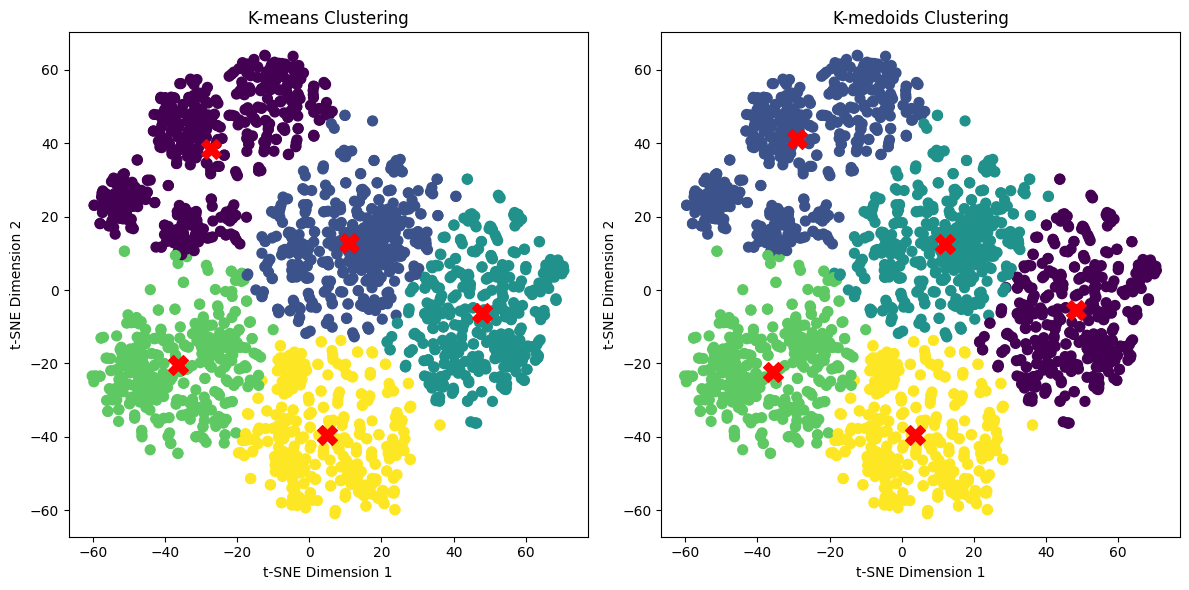

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

#K-means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
kmeans_labels = kmeans.fit_predict(X_tsne)
kmeans_centers = kmeans.cluster_centers_

#K-medoids
kmedoids = KMedoids(n_clusters=k, random_state=42)
kmedoids_labels = kmedoids.fit_predict(X_tsne)
kmedoids_centers = X_tsne[kmedoids.medoid_indices_]

# plot
plt.figure(figsize=(12, 6))

# K-means
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, s=50, cmap='viridis')
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', marker='X', s=200)
plt.title('K-means Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# K-medoids
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmedoids_labels, s=50, cmap='viridis')
plt.scatter(kmedoids_centers[:, 0], kmedoids_centers[:, 1], c='red', marker='X', s=200)
plt.title('K-medoids Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()


#### Hierarchical

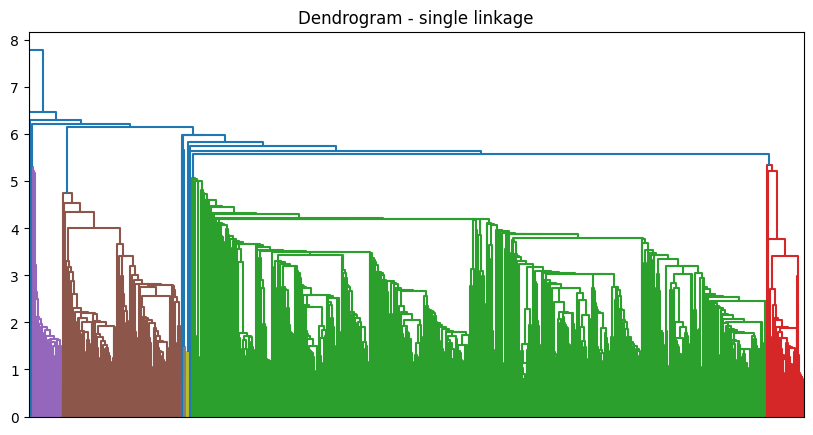

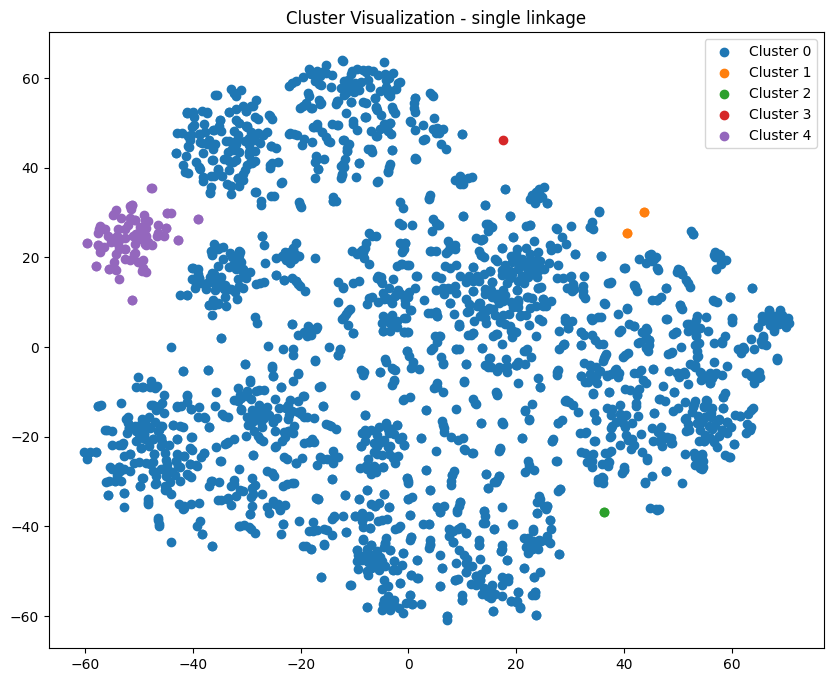

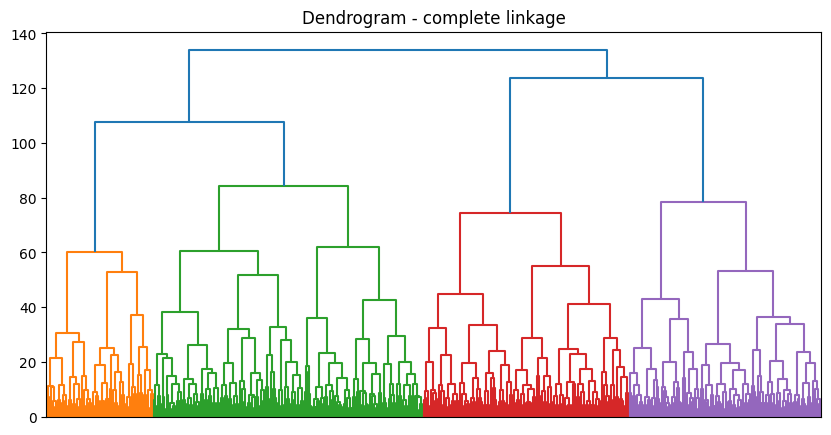

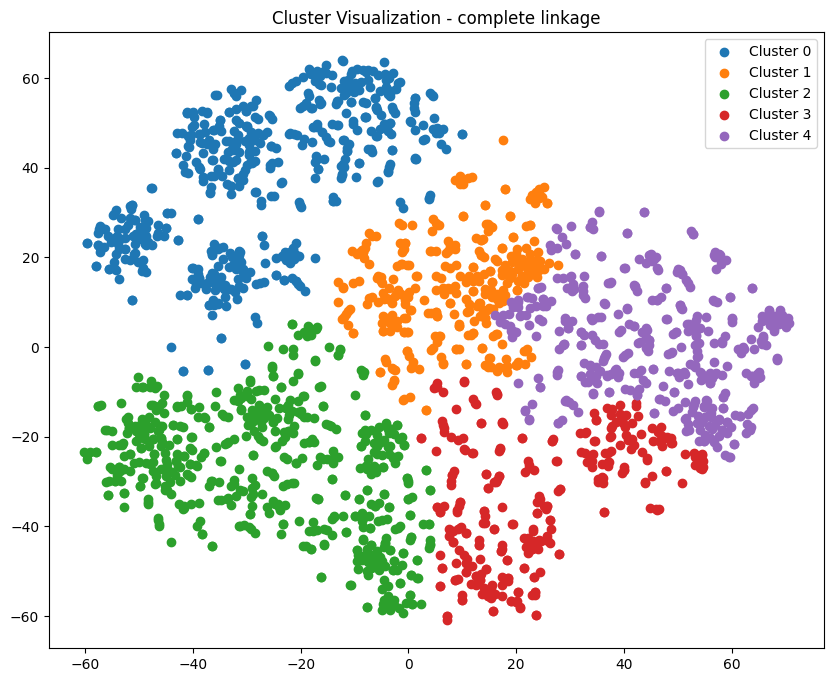

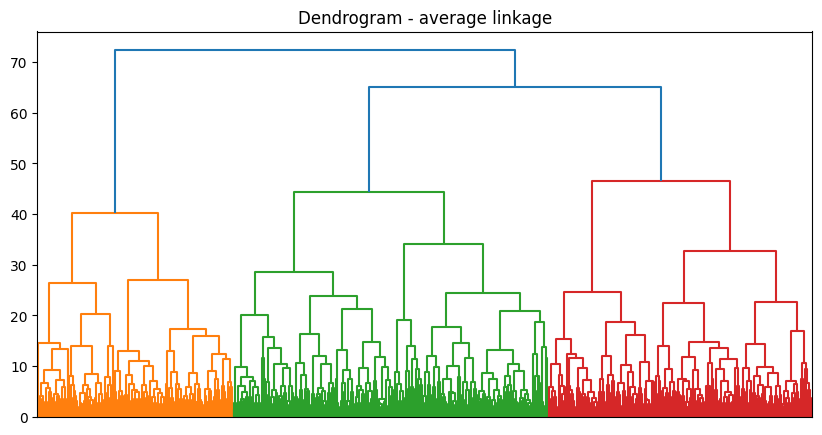

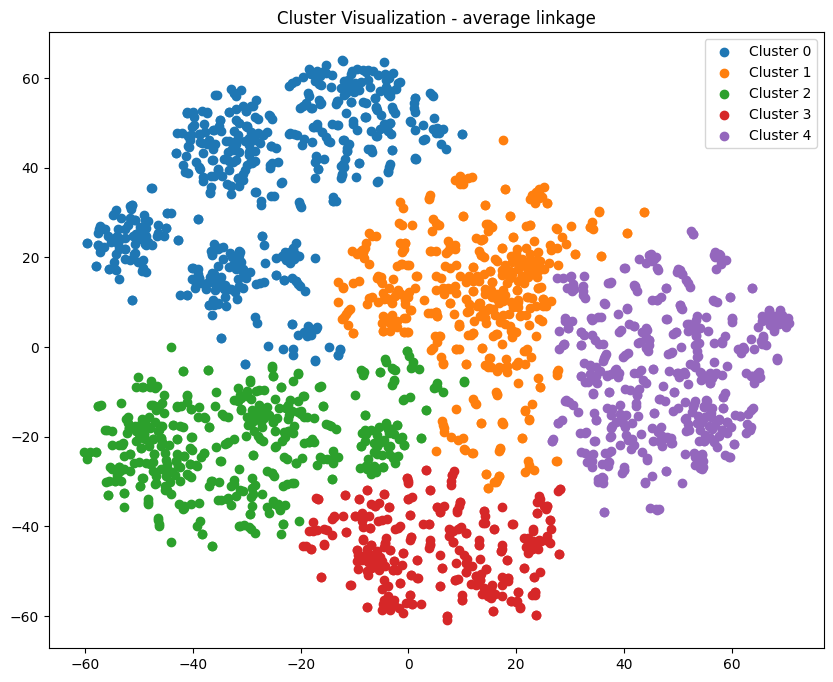

In [9]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


linkage_types = ["single", "complete", "average"]

for linkage_type in linkage_types:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage=linkage_type)
    labels = hierarchical.fit_predict(X_tsne)

    # Generate dendrogram
    linkage_matrix = linkage(X_tsne, method=linkage_type)
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.title(f"Dendrogram - {linkage_type} linkage")
    plt.xticks([])
    plt.show()

    # Visualize clusters in a 2D scatter plot
    plt.figure(figsize=(10, 8))
    for cluster_id in range(k):
        cluster_indices = [i for i, label in enumerate(labels) if label == cluster_id]
        plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices, 1], label=f'Cluster {cluster_id}')

    plt.title(f"Cluster Visualization - {linkage_type} linkage")
    plt.legend()
    plt.show()


In [14]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

hierarchical = AgglomerativeClustering(n_clusters=k, linkage="complete")
hierarchical_labels = hierarchical.fit_predict(X_tsne)

#### Density-based

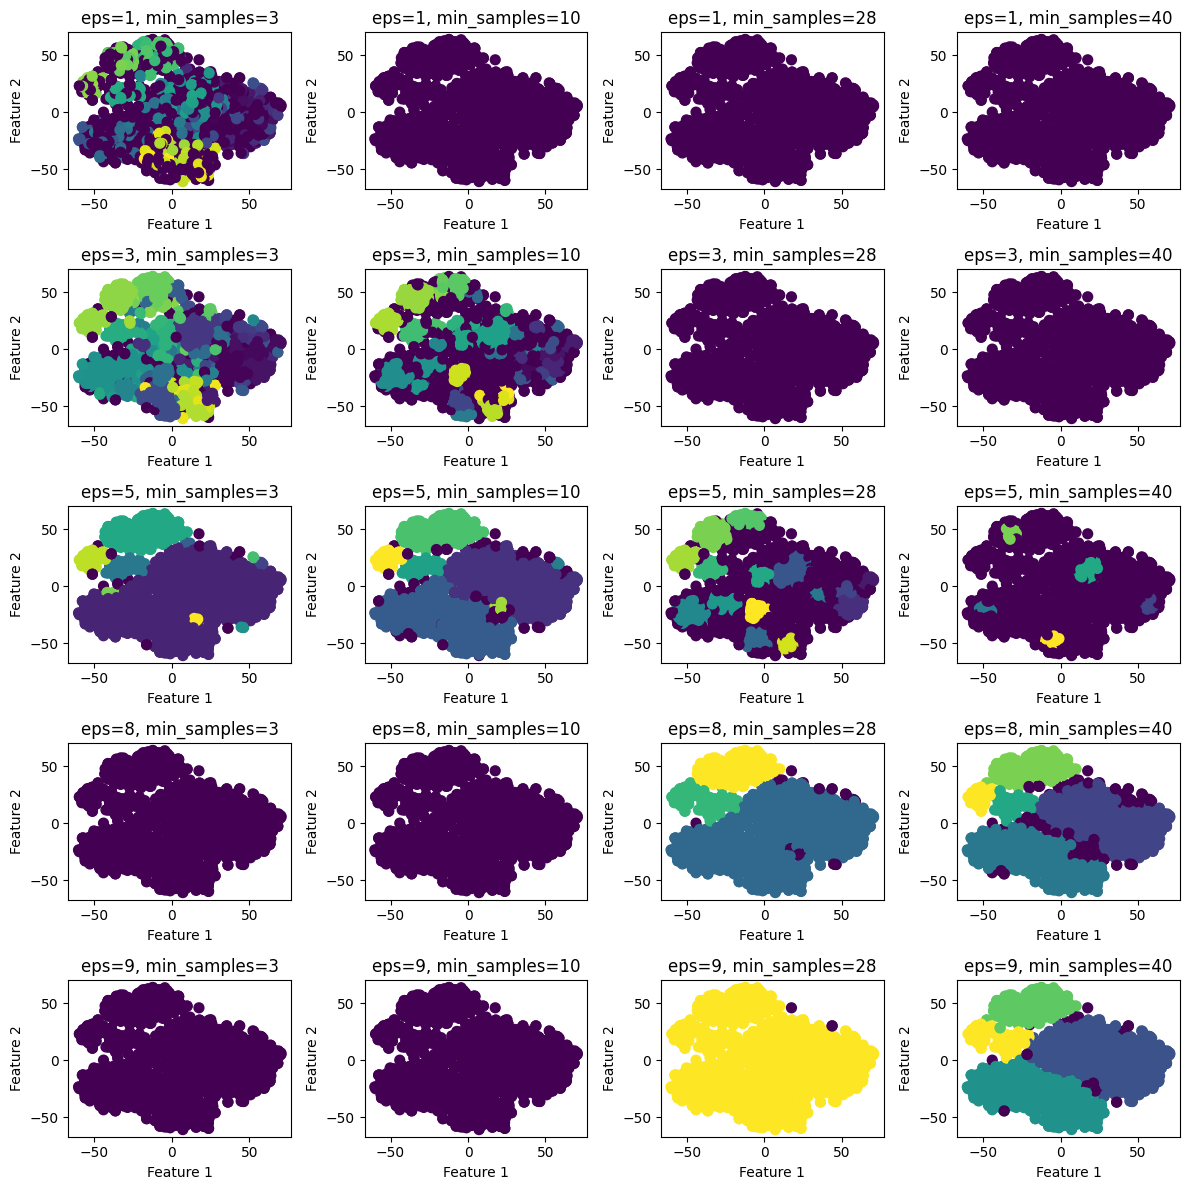

In [10]:
from sklearn.cluster import DBSCAN

eps_values = [1, 3, 5, 8, 9]
min_samples_values = [3, 10, 28, 40]


num_rows = len(eps_values)
num_cols = len(min_samples_values)

plt.figure(figsize=(12, 12))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_tsne)
        
        plt.subplot(num_rows, num_cols, i*num_cols + j + 1)
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', s=50)
        plt.title("eps={}, min_samples={}".format(eps, min_samples))
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


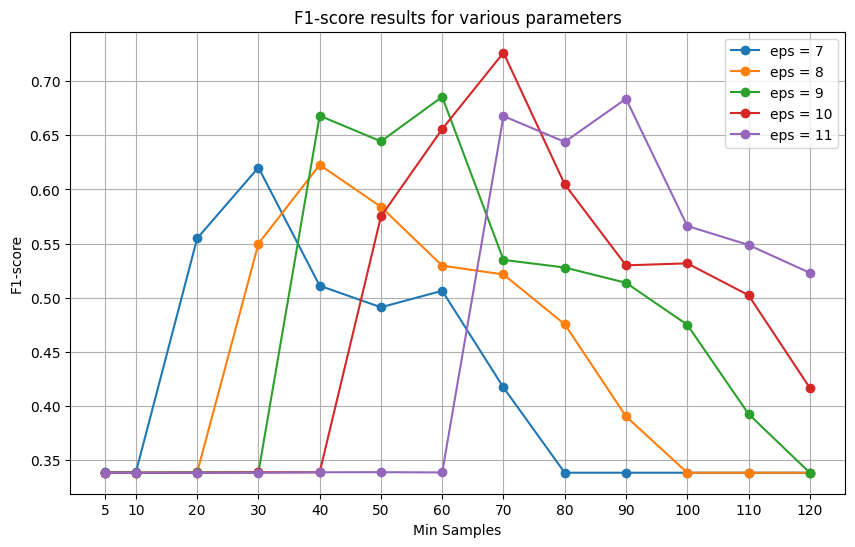

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

# counting bcubed
def compute_bcubed_metrics(category_labels, cluster_labels):
    precision = 0.0
    num_samples = len(category_labels)
    for i in range(num_samples):
        same_cluster = (cluster_labels == cluster_labels[i])
        same_category = (category_labels == category_labels[i])
        precision += np.mean(same_category[same_cluster])
    precision /= num_samples
    
    recall = 0.0
    for i in range(num_samples):
        same_cluster = (cluster_labels == cluster_labels[i])
        same_category = (category_labels == category_labels[i])
        recall += np.mean(same_cluster[same_category])
    recall /= num_samples
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1


# Parameters to test
#eps_values = [3,5,7,9,11]
eps_values = [7,8,9,10,11]

min_samples_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

best_params = ()
best_f1 = 0.

# list to storage results
f1_scores = []

# Experiment: searching the parameter space and collecting the results
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_tsne)
        
        precision, recall, f1 = compute_bcubed_metrics(real_labels, dbscan_labels)
        f1_scores.append(f1)

        if f1 > best_f1:
            best_f1 = f1
            best_params = (eps, min_samples)


import matplotlib.pyplot as plt

# plot
plt.figure(figsize=(10, 6))
for i, eps_value in enumerate(eps_values):
    plt.plot(min_samples_values, f1_scores[i * len(min_samples_values):(i + 1) * len(min_samples_values)], marker='o', label=f'eps = {eps_value}')

plt.title('F1-score results for various parameters')
plt.xlabel('Min Samples')
plt.ylabel('F1-score')
plt.xticks(min_samples_values)
plt.legend()
plt.grid()
plt.show()


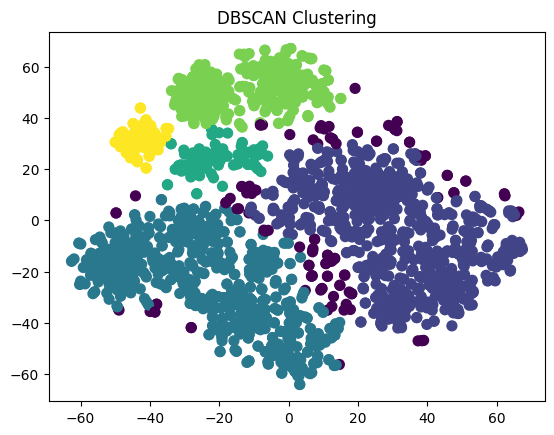

In [15]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Parameters
eps = 7
min_samples = 30

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title("DBSCAN Clustering")
plt.show()


#### Gaussian Mixture Model (GMM)

In [21]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=k, random_state=42)
gmm_labels = gmm.fit_predict(X_tsne)


In [23]:
# parametres for each cluster
cluster_means = gmm.means_
cluster_covariances = gmm.covariances_
cluster_weights = gmm.weights_

for i in range(k):
    print(f"Cluster {i+1} - Mean: {cluster_means[i]}, Covariance: {cluster_covariances[i]}, Weight: {cluster_weights[i]}")

Cluster 1 - Mean: [-36.2881579  -21.57377224], Covariance: 135.04397253071892, Weight: 0.1655957008216644
Cluster 2 - Mean: [13.2863964  11.30578329], Covariance: 166.31904999744853, Weight: 0.1848244003464869
Cluster 3 - Mean: [-24.8772591   35.47923417], Covariance: 296.12918907844556, Weight: 0.26611155324224584
Cluster 4 - Mean: [47.41405585 -6.05103679], Covariance: 175.41769961106309, Weight: 0.20007098044263372
Cluster 5 - Mean: [  4.5375791  -39.01027835], Covariance: 170.26263508553473, Weight: 0.18339736514696917


Testing covariance_type: full


C:\Users\julia\AppData\Local\Temp\ipykernel_3284\3496707137.py:51: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellip = Ellipse(cluster_means[j], width, height, angle, color=cluster_colors[j], alpha=0.2)


Testing covariance_type: tied


C:\Users\julia\AppData\Local\Temp\ipykernel_3284\3496707137.py:51: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellip = Ellipse(cluster_means[j], width, height, angle, color=cluster_colors[j], alpha=0.2)


Testing covariance_type: diag


C:\Users\julia\AppData\Local\Temp\ipykernel_3284\3496707137.py:51: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellip = Ellipse(cluster_means[j], width, height, angle, color=cluster_colors[j], alpha=0.2)


Testing covariance_type: spherical


C:\Users\julia\AppData\Local\Temp\ipykernel_3284\3496707137.py:51: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellip = Ellipse(cluster_means[j], width, height, angle, color=cluster_colors[j], alpha=0.2)


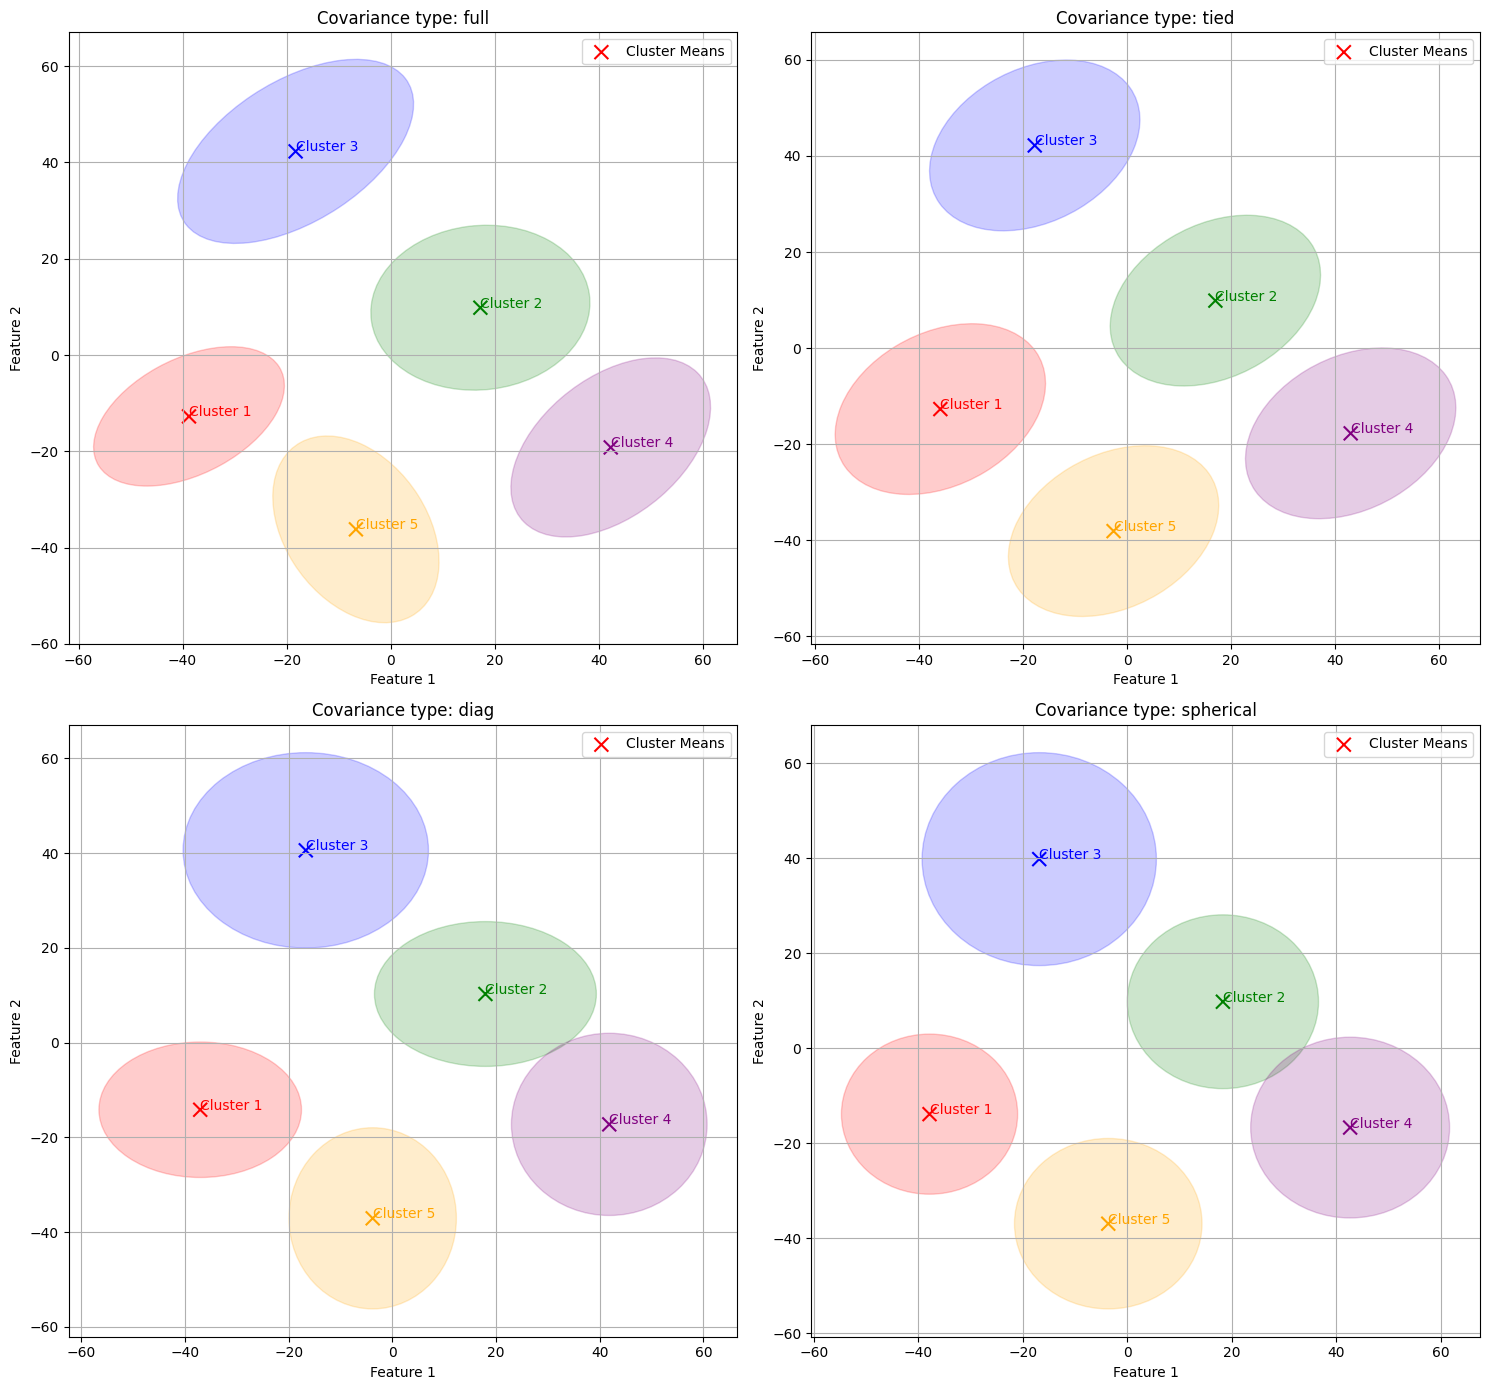

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn import mixture



# Test different covariance_type
covariance_types = ['full', 'tied', 'diag', 'spherical']
num_rows = len(covariance_types) // 2 + len(covariance_types) % 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 7*num_rows))
axs = axs.flatten()

for i, cov_type in enumerate(covariance_types):
    print(f"Testing covariance_type: {cov_type}")
    
    gmm = mixture.GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
    gmm_labels = gmm.fit_predict(X_tsne)

    # parameters of each cluster
    cluster_means = gmm.means_
    cluster_covariances = gmm.covariances_
    cluster_weights = gmm.weights_

    cluster_colors = ['red', 'green', 'blue', 'purple', 'orange']

    # clusters average
    axs[i].scatter(cluster_means[:, 0], cluster_means[:, 1], c=cluster_colors, marker='x', s=100, label='Cluster Means')

    # plot of contour ellipses for the covariance matrix
    for j in range(k):
        if gmm.covariance_type == 'spherical':
            width = height = 2 * np.sqrt(2) * np.sqrt(cluster_covariances[j])
        elif gmm.covariance_type == 'tied':
            eigvals, eigvecs = np.linalg.eigh(gmm.covariances_)
            width, height = 2 * np.sqrt(2) * np.sqrt(eigvals)
        else:
            cov_matrix = cluster_covariances[j]
            if cov_matrix.ndim == 1:
                cov_matrix = np.diag(cov_matrix)
            eigvals, eigvecs = np.linalg.eigh(cov_matrix)
            width, height = 2 * np.sqrt(2) * np.sqrt(eigvals)

        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        ellip = Ellipse(cluster_means[j], width, height, angle, color=cluster_colors[j], alpha=0.2)
        axs[i].add_patch(ellip)

    # add labels
    for j in range(k):
        axs[i].annotate(f'Cluster {j+1}', (cluster_means[j, 0], cluster_means[j, 1]), color=cluster_colors[j])

    axs[i].set_xlabel('Feature 1')
    axs[i].set_ylabel('Feature 2')
    axs[i].set_title(f'Covariance type: {cov_type}')
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()


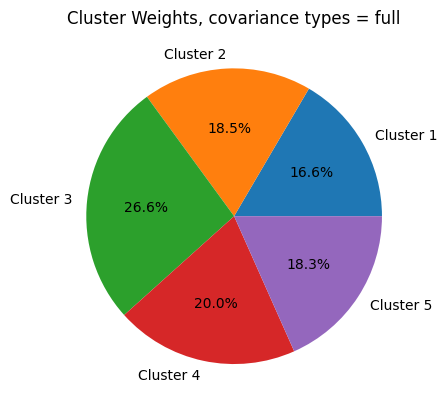

In [16]:
plt.pie(cluster_weights, labels=[f"Cluster {i+1}" for i in range(k)], autopct='%1.1f%%')
plt.title('Cluster Weights, covariance types = full')
plt.show()

#### Graph - based

In [2]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

affinities = ['rbf', 'nearest_neighbors']

for affinity in affinities:
    print(f"Affinity: {affinity}")
    
    # Spectral Clustering
    if affinity == 'precomputed':
        spectral_clustering = SpectralClustering(n_clusters=k, affinity=affinity, random_state=42)
        similarity_matrix = X.dot(X.T) 
        spectral_labels = spectral_clustering.fit_predict(similarity_matrix)
    else:
        spectral_clustering = SpectralClustering(n_clusters=k, affinity=affinity, random_state=42)
        spectral_labels = spectral_clustering.fit_predict(X_tsne)
    
    
    # plt
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, affinities.index(affinity) + 1)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=spectral_labels, cmap='rainbow')
    plt.title(f"Spectral Clustering Results - Affinity: {affinity}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.tight_layout()    

plt.show()


Affinity: rbf


In [17]:
from sklearn.cluster import SpectralClustering

# Klasteryzacja za pomocą Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral_clustering.fit_predict(X_tsne)

#### Table with results

In [18]:
from sklearn.preprocessing import LabelEncoder

# sssign cluster labels to data
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(df['category'])

# table with result
results = pd.DataFrame({
    'Real': category_labels,
    'K-means': kmeans_labels,
    'Hierarchical': hierarchical_labels,
    'DBSCAN': dbscan_labels,
    'GMM': gmm_labels,
    'Spectral': spectral_labels
})

print(results.head())



   Real  K-means  Hierarchical  DBSCAN  GMM  Spectral
0     0        2             1       0    3         1
1     0        2             1       0    3         1
2     0        2             1       0    3         1
3     0        2             1       0    3         1
4     0        2             1       0    3         1


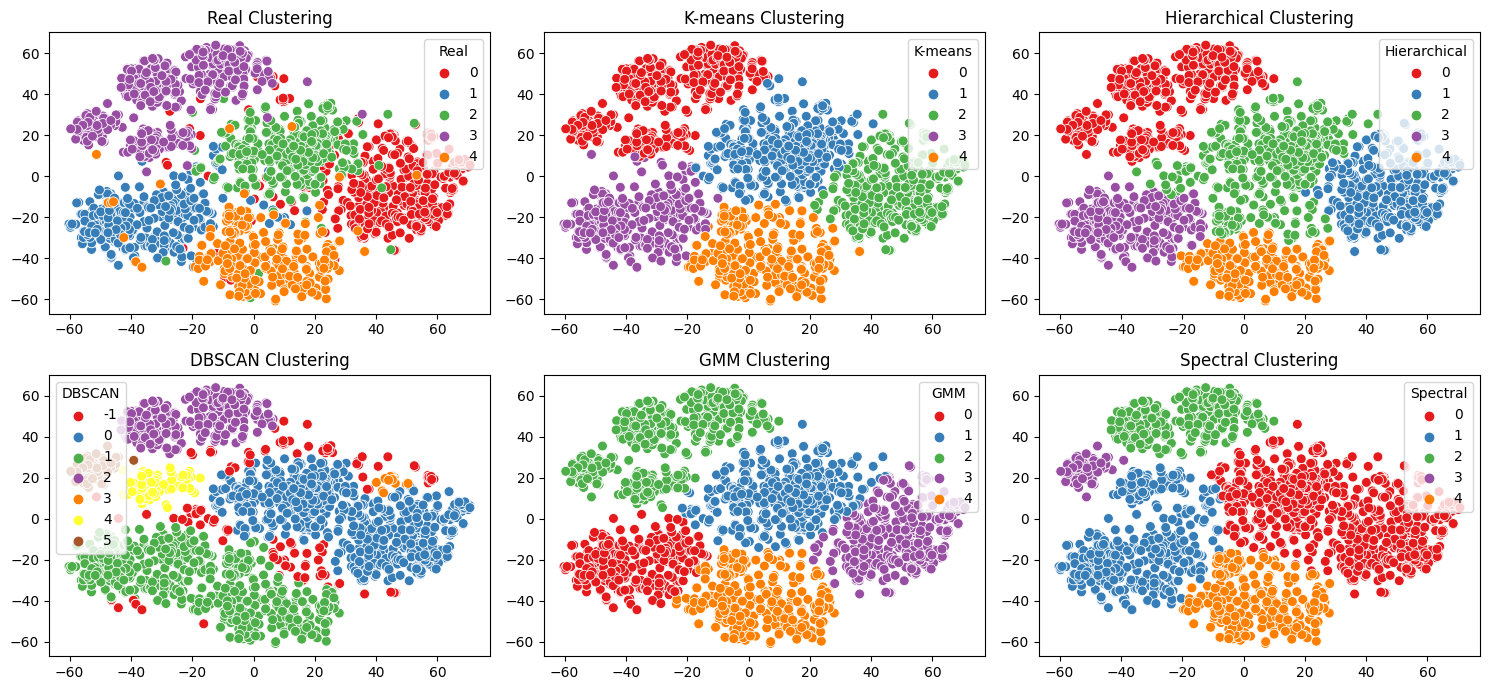

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
methods = results.columns

for i, method in enumerate(methods, start=1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=results[method], palette="Set1", s=50)
    plt.title(f'{method} Clustering')

plt.tight_layout()
plt.show()


In [19]:
# saving to CSV
results = results.iloc[:, 1:]  # Extract all columns except the 'Real' column
results.to_csv('results.csv', index=False)